In [1]:
import matplotlib
import matplotlib.pyplot as plt
import os
import logging
import glob

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [3]:
%ls '/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/TENSOR_RESULTS'

efficientdet-d0/  efficientdet-d3/


In [4]:
model = "efficientdet-d0"
config = "config_2"
output_directory = f'/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/FINE_TUNED_MODEL/{model}/{config}'

In [5]:
import pathlib

filenames = list(pathlib.Path(os.path.join(output_directory,"checkpoint")).glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_file = f"/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/models/research/deploy/{model}/{config}/pipeline_file.config"
pipeline_config = pipeline_file

#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/FINE_TUNED_MODEL/efficientdet-d0/config_2/checkpoint/ckpt-0.index')]


In [6]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [7]:
%cd /home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training

/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training


In [8]:
if "INFERENCE_DIR" not in os.listdir(os.getcwd()):
    os.mkdir(output_directory)
    logging.info("Creating the directory TENSOR_RESULTS because it did not exist") 
else:
    logging.info("The directory FINE_TUNED_MODEL is already present, files will be stored there") 

In [9]:
%cd /home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/INFERENCE_DIR

/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/INFERENCE_DIR


In [29]:
%ls /home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/INFERENCE_DIR

AdidasLogo.jpg  NikeLogo3.jpg  PumaLogo3.jpg
NFLogo1.jpg     PumaLogo.jpg   StarbucksLogo.jpg
NikeLogo.jpg    PumaLogo2.jpg  UnderArmourLogo2.jpg


In [27]:
import requests 

url = input("Insert the URL: ")
img_name = input("Pick a name for the image: ")
response = requests.get(url)

download_img = open(f"{img_name}.jpg", "wb")
download_img.write(response.content)
download_img.close()

Insert the URL: https://www.fontaniliabbigliamento.it/wp-content/uploads/2020/11/3C8D_R15_HERO-scaled.jpg
Pick a name for the image: NFLogo1


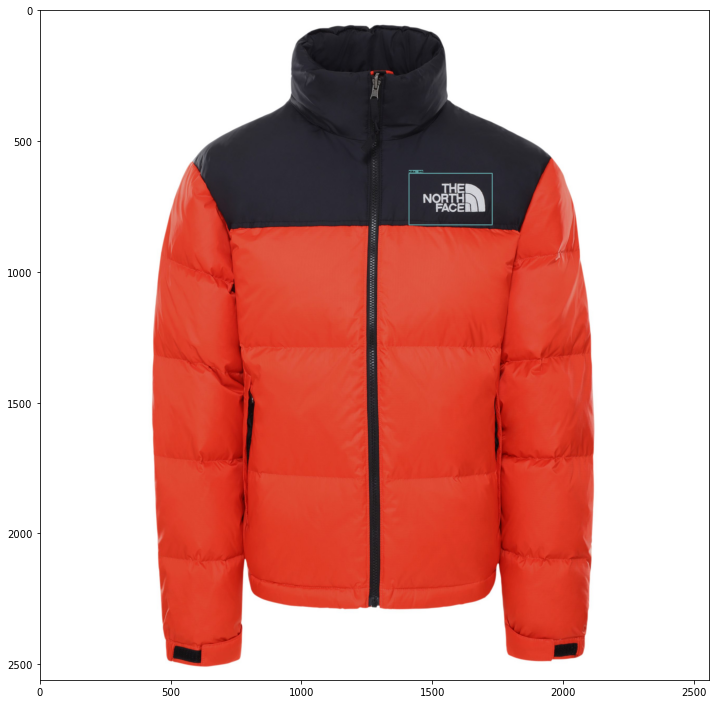

In [31]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

#TEST_IMAGE_PATHS = glob.glob('/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/INFERENCE_DIR/*.jpg')
#image_path = random.choice(TEST_IMAGE_PATHS)

image_path = "/home/labuser/LogoDet/LogoDetection_DSBAProject/training_process/training/INFERENCE_DIR/NFLogo1.jpg"
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
#image_np = np.tile(
#    np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True, # Needs to be true cause otherwise boxes go out of range
      max_boxes_to_draw=1, # Minimized to 10 because otherwise we might have troubles 
      min_score_thresh=0.80, # Minimized the score, as for now it seems to be too confident over Adidas
      agnostic_mode=False, # Set to False because it must be giving informations related to the boxes
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()